In [1]:
import numpy as np
import robosuite as suite

from PIL import Image
from IPython.display import display

In [2]:
from robosuite.utils.transform_utils import *
from transform import *

In [3]:
env = suite.make(
    env_name="Lift",
    robots="Panda",
    has_renderer=False,
    ignore_done=True,
    use_camera_obs=True,
    camera_names="frontview",
)

Creating offscreen glfw


In [4]:
def getBodyMat(body_name):
    body_id = env.sim.model.body_name2id(body_name)
    R = np.array(env.sim.data.body_xmat[body_id]).reshape(3, 3)
    p = np.array(env.sim.data.body_xpos[body_id])
    M_final = pose2mat(R, p)
    return M_final

In [5]:
jnt_idx = env.robots[0]._ref_joint_indexes
n = len(jnt_idx) # Franka is a 7-dof arm

for i in range(n):
    k = env.sim.model.jnt_bodyid[i]
    print(env.sim.model.body_id2name(k))

# reset the robot to its zero pose
env.reset()
env.robots[0].set_robot_joint_positions(np.zeros(n))

robot0_link1
robot0_link2
robot0_link3
robot0_link4
robot0_link5
robot0_link6
robot0_link7


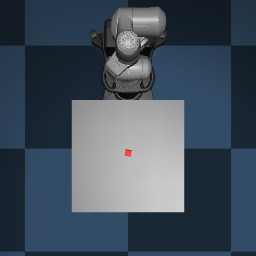

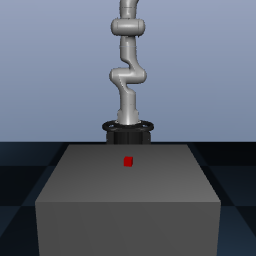

In [6]:
# set the arm to its zero position (all joint position = 0)
birdview = env.sim.render(height=256, width=256, camera_name="birdview")[::-1]
frontview = env.sim.render(height=256, width=256, camera_name="frontview")[::-1]
display(Image.fromarray(birdview), Image.fromarray(frontview))

In [7]:
# the configuration of the end-effector frame relative to 
# the fixed base frame in its zero pose
w0 = np.array(env.sim.data.xaxis)[jnt_idx]
p0 = np.array(env.sim.data.xanchor)[jnt_idx]
v0 = -np.cross(w0, p0)

theta0 = env.sim.data.qpos[jnt_idx]

M0 = dict()
for i in range(1, 8):
    body_name = "robot0_link{}".format(i)
    M0[body_name] = getBodyMat(body_name)

body_name = "robot0_right_hand"
M0[body_name] = getBodyMat(body_name)

# Joints are also bodies. These are two equivalent ways
# of retrieving the pose
body_idx = [env.sim.model.jnt_bodyid[x] for x in jnt_idx]
body_p0 = np.array(env.sim.data.body_xpos[body_idx])
assert np.allclose(body_p0, p0)

# sanity check (no motion no change)
# All Ts should be identity matrix
M = M0["robot0_right_hand"]
for i in reversed(range(n)):
    T = exp2mat(w0[i], v0[i], theta0[i])
    M = np.matmul(T, M)
assert np.allclose(M, M0["robot0_right_hand"])

In [8]:
low, high = env.action_spec # get action limits
for i in range(100):
    action = np.random.uniform(low, high) # sample random action
    obs, reward, done, _ = env.step(action)

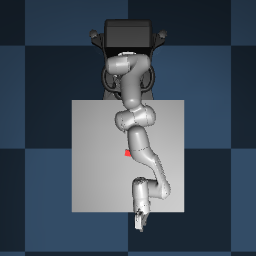

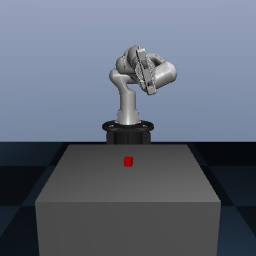

In [9]:
# visualize the new arm position
birdview = env.sim.render(height=256, width=256, camera_name="birdview")[::-1]
frontview = env.sim.render(height=256, width=256, camera_name="frontview")[::-1]
display(Image.fromarray(birdview), Image.fromarray(frontview))

In [10]:
# Product of Exponentials formula
body_name = "robot0_right_hand"
M = M0[body_name]

for i in reversed(range(n)):
    k = jnt_idx[i]
    theta = env.sim.data.qpos[k]
    T = exp2mat(w0[k], v0[k], theta)
    M = np.matmul(T, M)

R, p = mat2pose(M)
R_gt, p_gt = mat2pose(getBodyMat(body_name))

# compute rotation error as angle of the two rotations
R_err = np.arccos((np.trace(np.matmul(R, R_gt.T)) - 1)/2.0)
p_err = np.linalg.norm(p - p_gt)

print("rotation err:", R_err)
print("position err:", p_err)

rotation err: 0.0006822360541342619
position err: 0.00032969070448167926
